In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/Volumes/kaylab/Personal.Folders/BO/Python/DSB2017/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
# for some odd reason there are duplicate files for each folder. Each duplicate starts with '._'
for i in range(len(patients)):
    if '._' in patients[i]:
        patients[i] = []
patients = list(filter(None,patients))

In [3]:
# Load the scans in given folder path
def load_scan(path):
    # edited to skip all files starting with '._'
    # Also, file is missing 'DICM' marker. Use force=True to force reading
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path) if '._' not in s]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

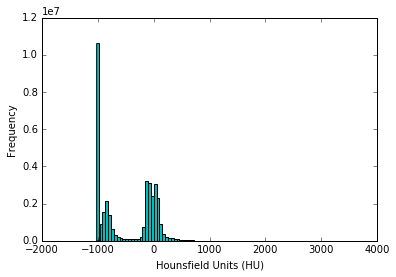

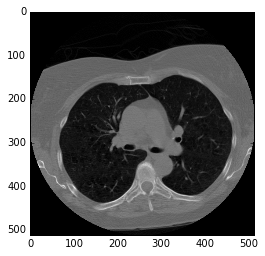

In [5]:
first_patient = load_scan(INPUT_FOLDER + patients[10])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [6]:
# Perform segmentation before resampling because we want to trim off excess 0s before resample

# Lung segmentation
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    # the background (air) label is -1
    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    # measure.label assigns unique numerical values to unconnected components
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    imdim = labels.shape[1] # added by Bo
    background_label = labels[0,0,0]
    background_label2 = labels[0,imdim-1,0]# added by Bo
    background_label3 = labels[0,0,imdim-1]# added by Bo
    background_label4 = labels[0,imdim-1,imdim-1]# added by Bo
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    binary_image[background_label2 == labels] = 2# added by Bo
    binary_image[background_label3 == labels] = 2# added by Bo
    binary_image[background_label4 == labels] = 2# added by Bo
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=-1)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=-1)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [7]:
#segmented_lungs = segment_lung_mask(pix_resampled, False)
#segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
segmented_lungs = segment_lung_mask(first_patient_pixels, False)
segmented_lungs_fill = segment_lung_mask(first_patient_pixels, True)

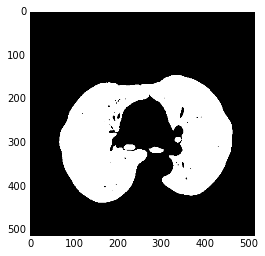

In [93]:
plt.imshow(segmented_lungs[80,:,:], cmap=plt.cm.gray)

In [8]:
# dilate segmented mask to include possible nodules on lung edges
kernel = np.ones((5,5),np.uint8)
dilated_mask = scipy.ndimage.morphology.binary_dilation(segmented_lungs_fill, iterations=5)

(136, 512, 512)
(136, 512, 512)


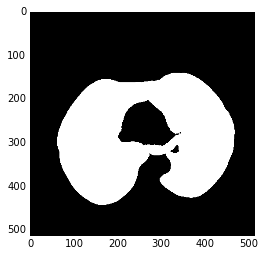

In [9]:
np.sum(dilated_mask[133,:,:])
plt.imshow(dilated_mask[80,:,:], cmap=plt.cm.gray)
print(dilated_mask.shape)
print(segmented_lungs_fill.shape)


In [10]:
# Trim excess 0s (to make mask smaller and higher res)
def trim_excess(mask, image):
    # This function assumes that z-axis (height) is the 1st coordinate
    height = mask.shape[0]
    width = mask.shape[1]
    
    # Use mask to determined edges of the trim
    ind = 0
    while np.sum(mask[ind,:,:]) == 0:
        ind += 1
    bottom = ind
    
    ind = 0
    while np.sum(mask[height-1-ind,:,:]) == 0:
        ind += 1
    top = ind
    
    ind = 0
    while np.sum(mask[:,ind,:]) == 0:
        ind += 1
    front = ind
    
    ind = 0
    while np.sum(mask[:,width-1-ind,:]) == 0:
        ind += 1
    back = ind
    
    ind = 0
    while np.sum(mask[:,:,ind]) == 0:
        ind += 1
    left = ind
    
    ind = 0
    while np.sum(mask[:,:,width-1-ind]) == 0:
        ind += 1
    right = ind
    
    trimmed_mask = mask[bottom:(height-top),front:(width-back),left:(width-right)]
    trimmed_image = image[bottom:(height-top),front:(width-back),left:(width-right)]
    
    return trimmed_mask, trimmed_image

(136, 355, 468)

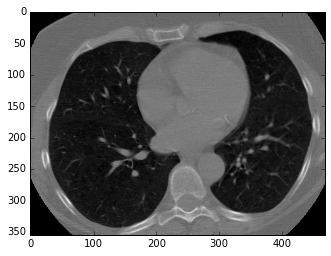

In [18]:
trimmed_mask, trimmed_pixels = trim_excess(dilated_mask, first_patient_pixels)
plt.imshow(trimmed_pixels[50,:,:], cmap=plt.cm.gray)
trimmed_pixels.shape

In [34]:
# 2 stage resampling

def resample(image, scan, new_spacing=[1,1,1], final_shape=[25,50,60]):
    # This function modified by Bo for 2-stage resampling
    # 1st stage: make pixel spacing equal in all directions
    # 2nd stage: downsample image shape
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    final_resize_factor = final_shape / new_shape
    image = scipy.ndimage.interpolation.zoom(image, final_resize_factor, mode='nearest')
    
    return image

In [96]:
pix_resampled = resample(trimmed_pixels, first_patient,[2,2,2], [60,100,120])
msk_resampled = resample(trimmed_mask, first_patient,[2,2,2], [60,100,120])
# runs faster with new_spacing = [2,2,2]
print("Shape before resampling\t", trimmed_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (136, 355, 468)
Shape after resampling	 (60, 100, 120)


//anaconda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


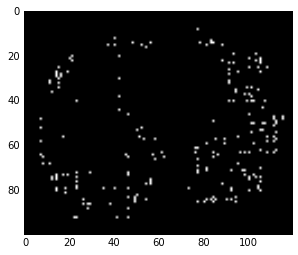

In [99]:
plt.imshow(msk_resampled[2], cmap=plt.cm.gray)

In [86]:
# 3D plotting
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

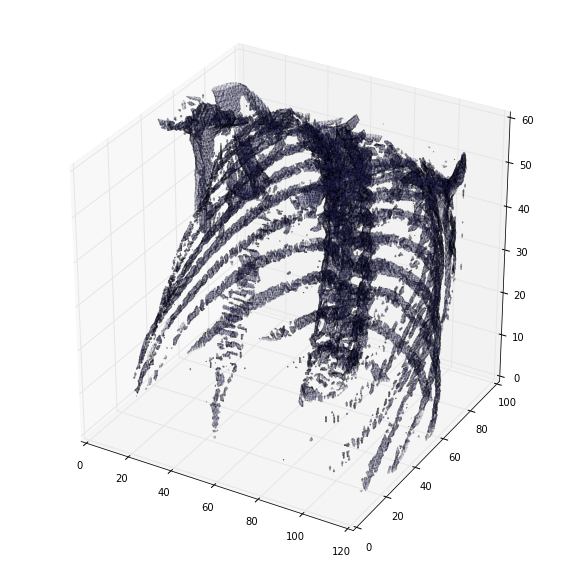

In [88]:
plot_3d(pix_resampled, 400)

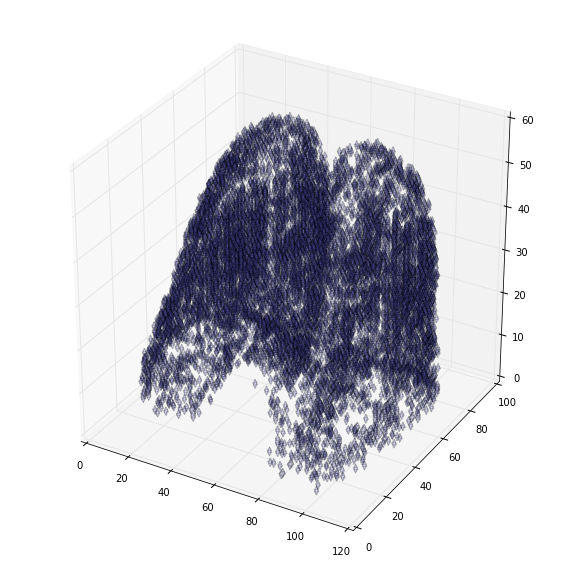

In [97]:
plot_3d(msk_resampled, 0)

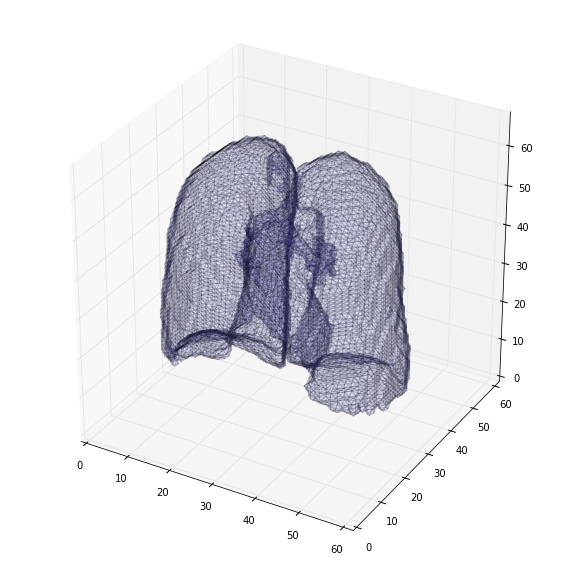

In [17]:
plot_3d(segmented_lungs_fill, 0)

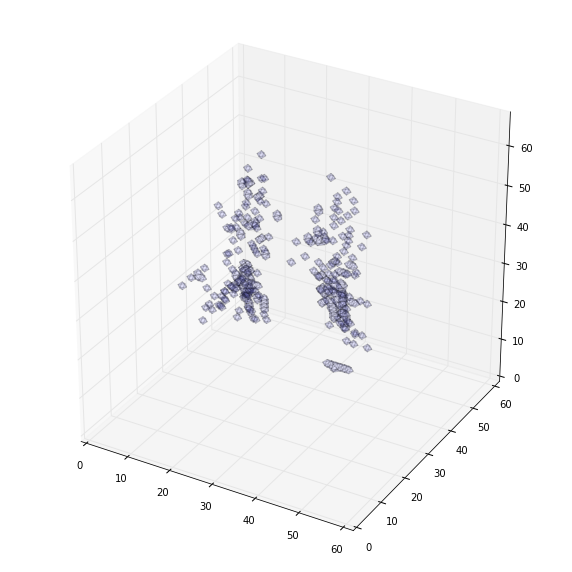

In [18]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [ ]:
# Normalization
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [ ]:
# Zero centering
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

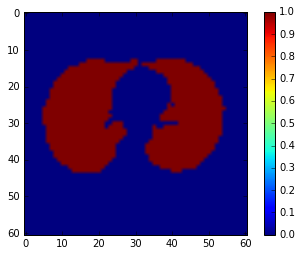

In [25]:
plt.imshow(segmented_lungs_fill[34,:,:])
plt.colorbar()

In [ ]:
INPUT_FOLDER + patients[0]

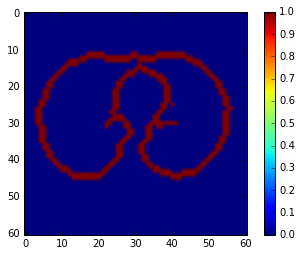

In [37]:
img = segmented_lungs_fill
kernel = np.ones((5,5),np.uint8)

dilated_mask = scipy.ndimage.morphology.binary_dilation(img, iterations=2)
plt.imshow(dilated_mask[34,:,:]-img[34,:,:])
plt.colorbar()

In [38]:
masked_image = pix_resampled
masked_image[dilated_mask==0] = 0

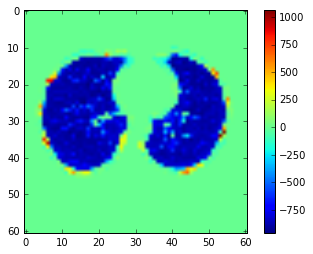

In [43]:
plt.imshow(masked_image[30,:,:])
plt.colorbar()

In [ ]:
patients

In [12]:
first_patient

[(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.74838062021175349002007423935132408637
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '0c60f4b87afcb3e2dfa65abbbf3ef2f9'
(0010, 0020) Patient ID                          LO: '0c60f4b87afcb3e2dfa65abbbf3ef2f9'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0050) Slice Thickness                     DS: '2.0'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.60662495564633805468505226801786163568539534060058594634718
(0020, 000e) Series Instance UID                 UI: 2.25.23177023242873676261568336453930869055631349502016160372923
(0020, 0011) Series Number               